In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from mamba_ssm import Mamba2
import os
import random
import gc
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from google.colab import drive

In [ ]:
# --- CONFIG ---
CONFIG = {
    'window_length': 128,
    'batch_size': 64,
    'd_state': 64,
    'n_layers': 4,
    'learning_rate': 5e-4,
    'num_epochs': 50,
    'dropout': 0.25,
    'num_classes': 21
}
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
FAULT_FREE_TRAIN_PATH = '/content/drive/MyDrive/csv/TEP_FaultFree_Training.csv'
FAULTY_TRAIN_PATH = '/content/drive/MyDrive/csv/TEP_Faulty_Training.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [ ]:
def prepare_tep_data_lazy(fault_free_path, faulty_path, window_length, param_output_path='normalization_params.csv'):
    print("1. Dosyalar okunuyor (Lazy Mod)...")

    # Feature isimlerini al
    temp_df = pd.read_csv(fault_free_path, nrows=0)
    feature_names = temp_df.columns[3:]

    # Ham verileri ve indeksleri tutacak listeler
    # train_raw_data: Tüm simülasyonların uc uca eklenmiş hali (Normalizasyon için)
    # train_indices: Her bir pencerenin raw_data üzerindeki başlangıç noktası
    # train_labels: Her bir pencerenin etiketi

    raw_data_list = []

    # Train/Val ayrımı için geçici listeler
    train_indices = []
    train_labels = []
    val_indices = []
    val_labels = []

    current_global_idx = 0

    def process_dataframe(df_path, is_faulty_dataset=False):
        nonlocal current_global_idx
        df = pd.read_csv(df_path)
        meta_data = df.iloc[:, :3].values
        sensor_data = df.iloc[:, 3:].values.astype(np.float32)

        del df
        gc.collect()

        fault_col = meta_data[:, 0]
        sim_col = meta_data[:, 1]
        unique_faults = np.unique(fault_col)

        for fault in unique_faults:
            fault_mask = (fault_col == fault)
            fault_sims = np.unique(sim_col[fault_mask])

            for sim in fault_sims:
                mask = (fault_col == fault) & (sim_col == sim)
                data_chunk = sensor_data[mask]

                chunk_len = len(data_chunk)
                if chunk_len < window_length:
                    continue

                # 1. Ham veriyi listeye ekle
                raw_data_list.append(data_chunk)

                # 2. Etiketleri Hesapla (Robust Logic)
                label_chunk = np.full(chunk_len, fault, dtype=np.int64)
                if is_faulty_dataset and len(label_chunk) >= 20:
                    label_chunk[:20] = 0

                # Window Labels hesaplama (Gürültü temizliği için)
                # Burada stride_tricks ile sadece label'lara bakıyoruz (hafıza dostu)
                label_windows = np.lib.stride_tricks.sliding_window_view(label_chunk, window_shape=window_length, axis=0)
                final_labels = label_windows[:, -1].copy()
                occurrence_counts = (label_windows == final_labels[:, None]).sum(axis=1)
                # GÜNCELLENDİ: Eşik değeri 4 -> 2 olarak değiştirildi
                final_labels[occurrence_counts < 2] = 0

                # 3. İndeksleri Hesapla
                # Bu chunk için geçerli pencere sayısı
                n_windows = len(final_labels)

                # Global veri üzerindeki başlangıç noktaları
                # current_global_idx, şu anki chunk'ın başlangıcı
                chunk_indices = np.arange(current_global_idx, current_global_idx + n_windows)

                # Train / Val Split (%85)
                split_pt = int(n_windows * 0.85)

                if split_pt > 0:
                    train_indices.append(chunk_indices[:split_pt])
                    train_labels.append(final_labels[:split_pt])

                if n_windows - split_pt > 0:
                    val_indices.append(chunk_indices[split_pt:])
                    val_labels.append(final_labels[split_pt:])

                # Global index'i güncelle
                current_global_idx += chunk_len

    # Dosyaları işle
    print(f" -> İşleniyor: {fault_free_path}")
    process_dataframe(fault_free_path, is_faulty_dataset=False)

    # --- DEĞİŞİKLİK: Normalizasyon parametrelerini sadece Fault Free veriden hesapla ---
    print(" -> Normalizasyon parametreleri hesaplanıyor (Sadece Fault Free)...")
    if len(raw_data_list) > 0:
        temp_ff = np.concatenate(raw_data_list, axis=0)
        mean = temp_ff.mean(axis=0, keepdims=True)
        std = temp_ff.std(axis=0, keepdims=True)
        std[std == 0] = 1e-8
        del temp_ff
        gc.collect()
    else:
        print("UYARI: Fault free veri bulunamadı!")
        mean = 0
        std = 1

    print(f" -> İşleniyor: {faulty_path}")
    process_dataframe(faulty_path, is_faulty_dataset=True)

    print("2. Raw Data Birleştiriliyor (Memory Optimized)...")
    # Tüm ham veriyi tek bir devasa array yapıyoruz
    X_raw = np.concatenate(raw_data_list, axis=0)
    del raw_data_list
    gc.collect()

    # İndeksleri birleştir
    train_indices = np.concatenate(train_indices, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    val_indices = np.concatenate(val_indices, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    print(f"Raw Data Shape: {X_raw.shape} (MB: {X_raw.nbytes / 1024**2:.2f})")
    print(f"Train Windows: {len(train_indices)}, Val Windows: {len(val_indices)}")

    # 3. Normalizasyon
    print("3. Normalizasyon (Fault-Free Params)...")
    # Parametreleri kaydet
    params_df = pd.DataFrame({'variable': feature_names, 'mean': mean.flatten(), 'std': std.flatten()})
    params_df.to_csv(param_output_path, index=False)

    # In-place normalizasyon (RAM tasarrufu)
    X_raw -= mean
    X_raw /= std
    X_raw = np.clip(X_raw, -5.0, 5.0)

    # Return raw data + indices instead of huge windowed arrays
    return X_raw, train_indices, train_labels, val_indices, val_labels

# Çağır
X_raw, train_idx, train_y, val_idx, val_y = prepare_tep_data_lazy(
    FAULT_FREE_TRAIN_PATH,
    FAULTY_TRAIN_PATH,
    CONFIG['window_length'],
    param_output_path='tep_normalization_params.csv'
)

1. Dosyalar okunuyor (Lazy Mod)...
 -> İşleniyor: /content/drive/MyDrive/csv/TEP_FaultFree_Training.csv
 -> Normalizasyon parametreleri hesaplanıyor (Sadece Fault Free)...
 -> İşleniyor: /content/drive/MyDrive/csv/TEP_Faulty_Training.csv
2. Raw Data Birleştiriliyor (Memory Optimized)...
Raw Data Shape: (5250000, 52) (MB: 1041.41)
Train Windows: 3328500, Val Windows: 588000
3. Normalizasyon (Fault-Free Params)...


In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

# --- LAZY DATASET CLASS ---
class TEPLazyDataset(Dataset):
    def __init__(self, raw_data, indices, labels, window_length):
        # raw_data: Tüm zaman serisi verisi (Total_T, Feat)
        # indices: Her bir örneğin başlangıç indeksi (N_samples,)
        # labels: Her bir örneğin etiketi (N_samples,)
        self.raw_data = torch.from_numpy(raw_data) # Paylaşılan hafıza (Tensor)
        self.indices = indices
        self.labels = torch.from_numpy(labels)
        self.window_length = window_length

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        start = self.indices[i]
        end = start + self.window_length

        # Slicing işlemi tensor üzerinde yapılır (copy oluşturmaz, view alır)
        # Ancak DataLoader batch oluştururken kopyalar.
        window = self.raw_data[start:end]
        label = self.labels[i]

        return window, label

# Datasetleri oluştur
train_dataset = TEPLazyDataset(X_raw, train_idx, train_y, CONFIG['window_length'])
val_dataset = TEPLazyDataset(X_raw, val_idx, val_y, CONFIG['window_length'])

print(f"Train Dataset Size: {len(train_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

Train Dataset Size: 3328500


In [ ]:
class MambaBlockLayer(nn.Module):
    def __init__(self, d_model, d_state=64, d_conv=4, expand=2, headdim=64, dropout=0.1):
        super().__init__()

        self.mamba = Mamba2(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
            headdim=headdim
        )
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_norm = self.norm(x)
        out = self.mamba(x_norm)
        out = self.dropout(out)
        return x + out

# --- 2. Boyut Düşürme Bloğu (Transition Layer) ---
class TransitionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.norm = nn.LayerNorm(out_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

# --- 3. Piramit Mamba Modeli (Sabit Boyutlu) ---
class PyramidMambaClassificationModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_state=64, dropout=0.1):
        super().__init__()

        # Kullanıcı İsteği: [64, 64, 32, 32]
        self.layer_dims = [64, 64, 32, 32]
        n_layers = len(self.layer_dims)

        # 1. Giriş Projeksiyonu
        first_dim = self.layer_dims[0]
        self.input_proj = nn.Linear(input_dim, first_dim)
        self.input_dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList()

        print(f"Model Mimarisi Oluşturuluyor (Layers: {self.layer_dims}, Headdim/d_state: {d_state}):")

        for i in range(n_layers):
            current_dim = self.layer_dims[i]
            print(f" -> Layer {i+1}: Mamba Block (Dim: {current_dim})")

            # A. Mamba Bloğu
            self.layers.append(
                MambaBlockLayer(
                    d_model=current_dim,
                    d_state=d_state,
                    headdim=d_state, # d_state kullanılıyor
                    dropout=dropout
                )
            )

            # B. Transition
            if i < n_layers - 1:
                next_dim = self.layer_dims[i+1]
                print(f"    -> Transition: {current_dim} => {next_dim}")
                self.layers.append(
                    TransitionLayer(current_dim, next_dim, dropout=dropout)
                )

        self.final_dim = self.layer_dims[-1]
        self.norm_f = nn.LayerNorm(self.final_dim)

        # 4. Sınıflandırıcı
        # GÜNCELLEME: Dropout kaldırıldı.
        self.classifier = nn.Sequential(
            nn.Linear(self.final_dim, self.final_dim // 2),
            nn.ReLU(),
            # nn.Dropout(dropout),  <-- İptal Edildi
            nn.Linear(self.final_dim // 2, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.input_dropout(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)

        # GÜNCELLEME: Weighted Pooling yerine Standard Average Pooling
        # Zaman eksenindeki (T) tüm adımların ortalamasını alır.
        x_pooled = x.mean(dim=1)

        logits = self.classifier(x_pooled)
        return logits

model = PyramidMambaClassificationModel(
    input_dim=52,
    num_classes=CONFIG['num_classes'],
    d_state=CONFIG['d_state'],    # Config'den gelen d_state (32)
    dropout=CONFIG['dropout']
).to(device)

print("\nModel Hazır (Sadeleştirilmiş Mimari).")

Model Mimarisi Oluşturuluyor (Layers: [64, 64, 32, 32], Headdim/d_state: 64):
 -> Layer 1: Mamba Block (Dim: 64)
    -> Transition: 64 => 64
 -> Layer 2: Mamba Block (Dim: 64)
    -> Transition: 64 => 32
 -> Layer 3: Mamba Block (Dim: 32)
    -> Transition: 32 => 32
 -> Layer 4: Mamba Block (Dim: 32)

Model Hazır (Sadeleştirilmiş Mimari).


In [ ]:
# 1. Loss ve Optimizer
criterion = nn.CrossEntropyLoss()
# AdamW genelleme performansı için Adam'dan daha iyidir
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-2)

# 2. Scheduler
# ReduceLROnPlateau: Loss iyileşmezse LR'yi düşürür.
# Bu scheduler yukarıdaki 'optimizer' nesnesine bağlıdır.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

In [ ]:
# Takip değişkenleri
best_val_loss = float('inf')
lr_reduce_count = 0
current_lr = CONFIG['learning_rate']

# --- TRAINING CONFIGURATION ---
# L4 GPU için BFloat16 Ayarı
print("Mode: BFloat16 (Scaler Disabled - L4 Optimized)")
dtype = torch.bfloat16

# --- TRAINING LOOP ---
print(f"Mamba Eğitimi Başlıyor...")

for epoch in range(CONFIG['num_epochs']):
    model.train()
    train_loss_acc = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{CONFIG['num_epochs']}] Train", leave=False)

    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        # BFloat16 Forward (Scaler yok)
        with torch.autocast(device_type='cuda', dtype=dtype):
            logits = model(inputs)
            loss = criterion(logits, labels)

        # Backward & Step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Metrikler
        train_loss_acc += loss.item()
        _, predicted = torch.max(logits.detach(), 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_bar.set_postfix(loss=loss.item())

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss_acc = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.autocast(device_type='cuda', dtype=dtype):
                logits = model(inputs)
                loss = criterion(logits, labels)

            val_loss_acc += loss.item()
            _, predicted = torch.max(logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_train_loss = train_loss_acc / len(train_loader)
    train_acc = 100 * correct_train / total_train

    avg_val_loss = val_loss_acc / len(val_loader)
    val_acc = 100 * correct_val / total_val

    # Scheduler Step
    scheduler.step(avg_val_loss)

    # Best Model Kaydı
    save_msg = ""
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_mamba_model.pth')
        save_msg = "-> 💾 KAYDEDİLDİ"

    # LR Kontrolü
    last_lr = optimizer.param_groups[0]['lr']
    if last_lr < current_lr:
        lr_reduce_count += 1
        current_lr = last_lr
        print(f"\n>>> 📉 Learning Rate Düştü! Yeni LR: {current_lr}")

    # Epoch Özeti
    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {avg_train_loss:.4f} Acc: %{train_acc:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} Acc: %{val_acc:.2f} {save_msg}")

    # Early Stopping
    if lr_reduce_count >= 3:
        print("\n!!! Early Stopping Tetiklendi (LR limiti). !!!")
        break

print("-" * 60)
print(f"Eğitim Tamamlandı. En iyi Validation Loss: {best_val_loss:.4f}")

Mode: BFloat16 (Scaler Disabled - L4 Optimized)
Mamba Eğitimi Başlıyor...


Epoch 01 | Train Loss: 0.0716 Acc: %97.01 | Val Loss: 0.0792 Acc: %97.56 -> 💾 KAYDEDİLDİ


Epoch 02 | Train Loss: 0.0318 Acc: %98.71 | Val Loss: 0.1182 Acc: %96.98 


Epoch 03 | Train Loss: 0.0231 Acc: %99.11 | Val Loss: 0.0740 Acc: %98.03 -> 💾 KAYDEDİLDİ


Epoch 04 | Train Loss: 0.0192 Acc: %99.27 | Val Loss: 0.0760 Acc: %98.15 


Epoch 05 | Train Loss: 0.0176 Acc: %99.35 | Val Loss: 0.1084 Acc: %97.74 


Epoch 06 | Train Loss: 0.0164 Acc: %99.40 | Val Loss: 0.0737 Acc: %98.18 -> 💾 KAYDEDİLDİ


Epoch 07 | Train Loss: 0.0156 Acc: %99.43 | Val Loss: 0.0947 Acc: %97.88 


Epoch 08 | Train Loss: 0.0149 Acc: %99.45 | Val Loss: 0.0549 Acc: %98.50 -> 💾 KAYDEDİLDİ


Epoch 09 | Train Loss: 0.0145 Acc: %99.47 | Val Loss: 0.1110 Acc: %97.48 


Epoch 10 | Train Loss: 0.0140 Acc: %99.49 | Val Loss: 0.0658 Acc: %98.31 


Epoch 11 | Train Loss: 0.0135 Acc: %99.51 | Val Loss: 0.1295 Acc: %97.52 



>>> 📉 Learning Rate Düştü! Yeni LR: 0.00025
Epoch 12 | Train Loss: 0.0134 Acc: %99.52 | Val Loss: 0.0830 Acc: %97.95 


Epoch [13/50] Train:  96%|█████████▌| 49798/52008 [29:37<01:18, 28.24it/s, loss=6.88e-5] 

En iyi model ağırlıkları yüklendi.

--- FAULT FREE TEST ---
Veri işleniyor (Stride=20): /content/drive/MyDrive/csv/TEP_FaultFree_Testing.csv


/tmp/ipython-input-2884787692.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)


Hata türleri taranıyor...
 -> Test Seti Hazır: (21000, 128, 52)
Tahminler alınıyor (Fault Free Data)...


--- Fault Free Data Sonuçları ---
Genel Doğruluk: %59.58
Yanlış Alarm Oranı (False Positive Rate): %40.42

--- FAULTY TEST ---
Veri işleniyor (Stride=20): /content/drive/MyDrive/csv/TEP_Faulty_Testing.csv


/tmp/ipython-input-2884787692.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)


Hata türleri taranıyor...
 -> Test Seti Hazır: (420000, 128, 52)
Tahminler alınıyor (Faulty Data)...


--- Faulty Data Sonuçları ---
Genel Doğruluk: %90.42


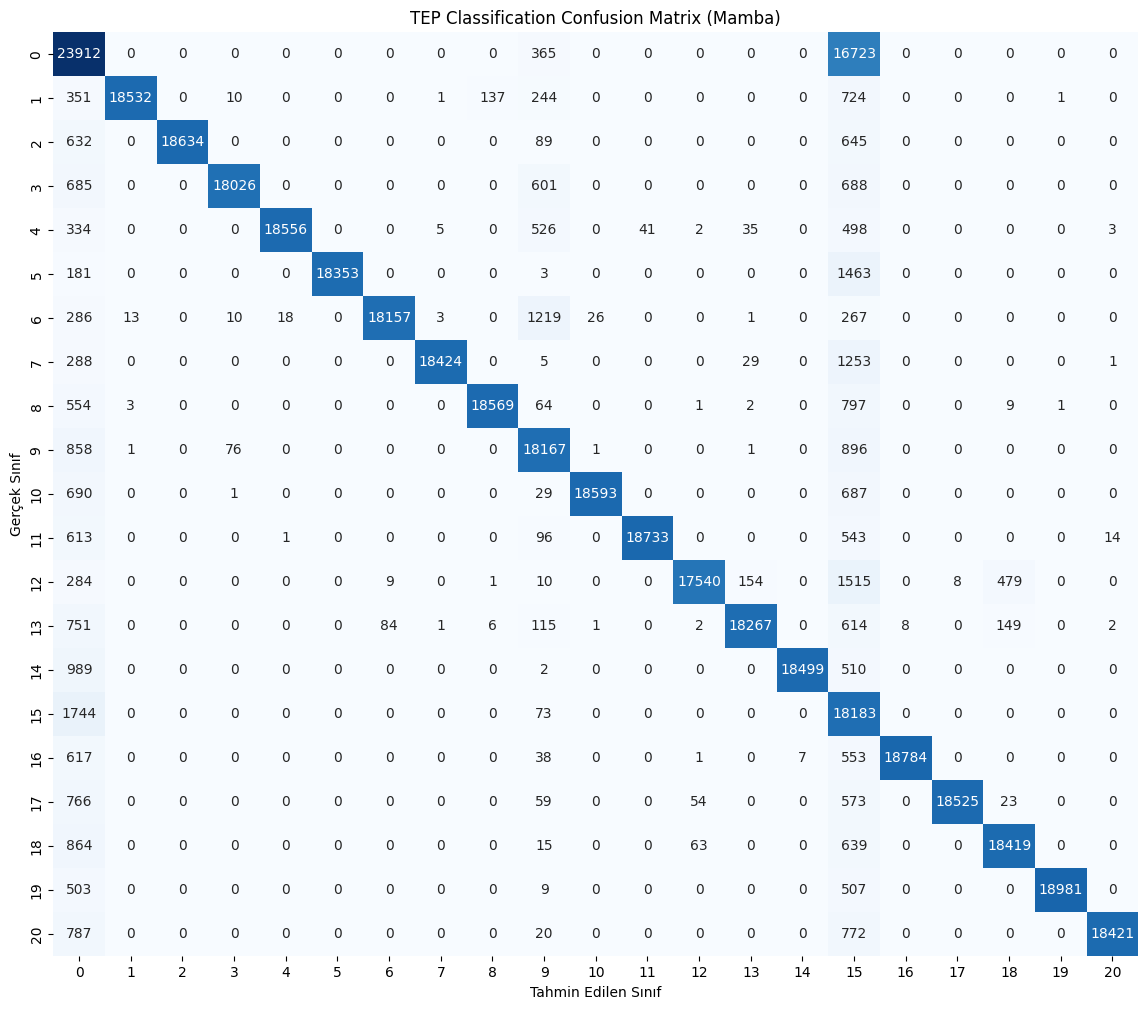

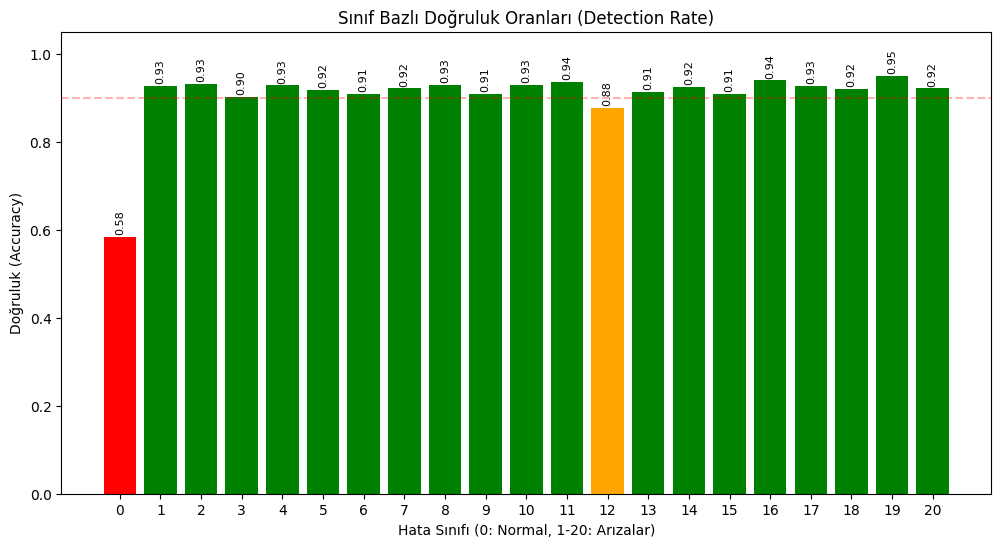

In [13]:
CONFIG['batch_size'] = 512

# Dataset Sınıfı
class TEPTestDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# Yardımcı Fonksiyon
def create_windows_vectorized(data, window_length, stride=1):
    windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=window_length, axis=0)[::stride]
    windows = windows.transpose(0, 2, 1)
    return windows

# Veri Hazırlama Fonksiyonu
def prepare_test_data(csv_path, window_length, norm_params_path, stride=20):
    print(f"Veri işleniyor (Stride={stride}): {csv_path}")

    params_df = pd.read_csv(norm_params_path)
    mean_vec = params_df['mean'].values.astype(np.float32)
    std_vec = params_df['std'].values.astype(np.float32)

    df = pd.read_csv(csv_path)
    df = df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)

    meta_data = df.iloc[:, :3].values
    sensor_data = df.iloc[:, 3:].values.astype(np.float32)

    sensor_data = (sensor_data - mean_vec) / std_vec
    sensor_data = np.clip(sensor_data, -5.0, 5.0)

    X_list = []
    y_list = []

    fault_col = meta_data[:, 0]
    sim_col = meta_data[:, 1]
    unique_faults = np.unique(fault_col)

    print(f"Hata türleri taranıyor...")

    for fault in unique_faults:
        current_fault_mask = (fault_col == fault)
        unique_sims = np.unique(sim_col[current_fault_mask])

        for sim in unique_sims:
            mask = (fault_col == fault) & (sim_col == sim)
            data_chunk = sensor_data[mask]

            if len(data_chunk) < window_length:
                continue

            label_chunk = np.full(len(data_chunk), fault, dtype=np.int64)
            # Test setinde ilk 160 örnek (8 saat) normal kabul edilir
            if len(label_chunk) >= 160:
                label_chunk[:160] = 0

            windows = create_windows_vectorized(data_chunk, window_length, stride=stride)

            label_windows = np.lib.stride_tricks.sliding_window_view(
                label_chunk, window_shape=window_length
            )[::stride]

            final_labels = label_windows[:, -1]

            if len(windows) > 0:
                X_list.append(windows)
                y_list.append(final_labels)

    if len(X_list) > 0:
        X_test = np.concatenate(X_list, axis=0)
        y_test = np.concatenate(y_list, axis=0)
    else:
        X_test, y_test = np.array([]), np.array([])

    print(f" -> Test Seti Hazır: {X_test.shape}")
    return X_test, y_test

# Modeli Değerlendirme Fonksiyonu
def evaluate_model(model, X, y, batch_size=512, title="Test"):
    dataset = TEPTestDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    all_preds = []
    all_labels = []

    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

    print(f"Tahminler alınıyor ({title})...")
    model.eval()

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Inference", leave=False):
            inputs = inputs.to(device)

            with torch.autocast(device_type='cuda', dtype=dtype):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    if len(all_labels) > 0:
        acc = accuracy_score(all_labels, all_preds)
        print(f"--- {title} Sonuçları ---\nGenel Doğruluk: %{acc*100:.2f}")
    else:
        print(f"--- {title} --- : Veri yok/boş.")

    return all_labels, all_preds


FAULT_FREE_PATH = '/content/drive/MyDrive/csv/TEP_FaultFree_Testing.csv'
FAULTY_PATH = '/content/drive/MyDrive/csv/TEP_Faulty_Testing.csv'
NORM_PARAMS_PATH = 'tep_normalization_params.csv'
MODEL_PATH = 'best_mamba_model.pth'

# Modeli Yükle (PyramidMambaClassificationModel sınıfının tanımlı olduğundan emin olun)
# model = PyramidMambaClassificationModel(
#     input_dim=52,
#     num_classes=CONFIG['num_classes'],
#     d_model=128,
#     d_state=CONFIG['d_state'],
#     n_layers=4,
#     dropout=CONFIG['dropout'],
#     reduction_factor=0.75
# ).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("En iyi model ağırlıkları yüklendi.")

# 1. Fault Free Test
print("\n--- FAULT FREE TEST ---")
try:
    X_ff, y_ff = prepare_test_data(FAULT_FREE_PATH, CONFIG['window_length'], NORM_PARAMS_PATH)
    # DÜZELTME: 'model' parametresi eklendi
    labels_ff, preds_ff = evaluate_model(model, X_ff, y_ff, title="Fault Free Data")

    if len(preds_ff) > 0:
        false_positives = (preds_ff != 0).sum()
        fp_rate = false_positives / len(preds_ff)
        print(f"Yanlış Alarm Oranı (False Positive Rate): %{fp_rate*100:.2f}")

except Exception as e:
    print(f"Fault Free verisi okunamadı: {e}")
    labels_ff, preds_ff = np.array([]), np.array([])

# 2. Faulty Test
print("\n--- FAULTY TEST ---")
try:
    X_faulty, y_faulty = prepare_test_data(FAULTY_PATH, CONFIG['window_length'], NORM_PARAMS_PATH)
    # DÜZELTME: 'model' parametresi eklendi
    labels_faulty, preds_faulty = evaluate_model(model, X_faulty, y_faulty, title="Faulty Data")

except Exception as e:
    print(f"Faulty verisi okunamadı: {e}")
    labels_faulty, preds_faulty = np.array([]), np.array([])

# --- GÖRSELLEŞTİRME ---
if len(labels_ff) > 0 or len(labels_faulty) > 0:

    if len(labels_ff) > 0 and len(labels_faulty) > 0:
        all_true = np.concatenate([labels_ff, labels_faulty])
        all_pred = np.concatenate([preds_ff, preds_faulty])
    else:
        all_true = labels_faulty if len(labels_faulty) > 0 else labels_ff
        all_pred = preds_faulty if len(preds_faulty) > 0 else preds_ff

    # Confusion Matrix
    cm = confusion_matrix(all_true, all_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('TEP Classification Confusion Matrix (Mamba)')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.ylabel('Gerçek Sınıf')
    plt.show()

    # Per-Class Accuracy
    # DÜZELTME: Sıfıra bölme hatası önlendi
    class_acc = cm.diagonal() / (cm.sum(axis=1) + 1e-10)

    plt.figure(figsize=(12, 6))
    colors = ['green' if x > 0.9 else 'orange' if x > 0.7 else 'red' for x in class_acc]
    plt.bar(range(len(class_acc)), class_acc, color=colors)
    plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.3)
    plt.title('Sınıf Bazlı Doğruluk Oranları (Detection Rate)')
    plt.xlabel('Hata Sınıfı (0: Normal, 1-20: Arızalar)')
    plt.ylabel('Doğruluk (Accuracy)')
    plt.xticks(range(len(class_acc)))
    plt.ylim(0, 1.05)

    for i, v in enumerate(class_acc):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=8, rotation=90)

    plt.show()
else:
    print("Görselleştirilecek veri yok.")